# COMP3222/6246 Machine Learning Technologies (2018/19)
# Week 2 – Basics of Machine Learning project

In this week, we will have an overview of how a practical Machine Learning project works. We aim to familiarise you with the general procedure of doing Machine Learning, while encouraging you to develop your critical thinking by asking you some questions now and then. 

In general, a Machine Learning project is not different from a software project, where you might want to go back and forth and tweak something, or roll out the first prototype and improve on it incrementally. Answering the questions will help you understand more, and allow you to come up with an idea for improving the Machine Learning prototype we introduced here.

Note that you will not learn by simply executing this notebook without playing with it :)

## Defining the problem

Say, we are given a task to **predict a house price in California**. Depending on a dataset, this can be either a *supervised learning*, *reinforcement learning*, and so on. Clearly, we need to inspect the dataset first.

## Getting the dataset

We will use 1990 California consus data which is provided by Aurélien Géron on his Github: https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz. The description of this dataset is provided on https://github.com/ageron/handson-ml/blob/master/datasets/housing/README.md and http://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html.

In [0]:
import urllib # This is URL handling module required for downloading files from the Internet

urllib.request.urlretrieve("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz", "housing.tgz")

In [0]:
import tarfile # This is used for decompressing .tgz file

housing_tgz = tarfile.open("housing.tgz")
housing_tgz.extractall()
housing_tgz.close()

The *housing.tgz* file should be decompressed and saved on the current working directory as *housing.csv*.

## Exploring the dataset

Now, we should familiarise ourselves with the dataset. For example, you should know what kind of attributes (*numerical* or *categorical*?), how many datapoints, how many missing values, is it raw data or transformed data, and so forth. 

Note that, usually, a dataset that you will acquire in the real world cannot be used right away. You will need to perform *data cleaning* beforehand.

In [0]:
import pandas # This is a library that is mainly used for data manipulation and some basic analyses

housing = pandas.read_csv("housing.csv")
housing.head()

In [0]:
housing.info()

In [0]:
housing.describe()

In [0]:
housing["ocean_proximity"].value_counts()

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt # This is for making a plot similar to one in MATLAB
housing.hist(bins=50, figsize=(20,15)) # Do you know why we choose 50 bins? Try playing with the number of bins and observe the difference.
plt.show()

What can we say about our dataset after this quick glance over it? What is the name of the variable that we need to predict with our Machine Learning technique? How many attributes or features do we have? Which attributes are numerical and which are not? Are there any missing values in the dataset? Is there any anomaly or outlier in the distribution of the attributes (shown in histogram)?

The more we know about our dataset, the less problems we will have later.

## Defining the problem and a performance measure

After we have roughly explored the dataset, we now know that we need to solve a supervised-learning multivariate regression task, where we will use a Machine Learning algorithm **to predict *median_house_value* based on other attributes**. With this knowledge, you will be able to select a number of appropriate algorithms later.

Moreover, we can pick a performance measure of our Machine Learning algorithm beforehand. There are a number of performance measures for regression task, but we will just use the Root Mean Square Error (RMSE) for now.

$$\text{RMSE} \left( \mathbf{Y} , \mathbf{\hat{Y}} \right) = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( y_i - \hat{y_i} \right)^2 } $$

where $\mathbf{Y}$ and $\mathbf{\hat{Y}}$ are an $n$-sized vector of true values and an $n$-sized vector of predicted values which comprises of $y_i$ and $\hat{y_i}$ respectively for each datapoint $i$. In other words, RMSE is computed from a square root of an average squared error.

Another well-known performance measure is the Mean Absolute Error (MAE), which is computed by taking an average of an absolute value of the error.

$$\text{MAE} \left( \mathbf{Y} , \mathbf{\hat{Y}} \right) = \frac{1}{n} \sum_{i=1}^n | y_i - \hat{y_i} | $$

Both of them are good measures of how well our Machine Learning algorithm will perform. The lower the value is, the better our algorithm performs. However, different measures will pick up different aspects in the error that our Machine Learning produced. Now, what is the difference between the RMSE and the MAE in this regard? Which one would be appropriate for this house price prediction task? Why?

## Data cleaning: missing values and capped values

By exploring our dataset, we are aware of at least 2 problems: namely, missing values and capped values. In particular, the attribute total_bedrooms has a number of values smaller than the other attributes, and there is a peak in the distribution of the attributes housing_median_age and median_house_value, which signifies a limit on the attribute's maximum value. These might be caused by how the data was collected; e.g. the survey's choice 'Prefer not to say', '>= 52', or '>= 500,001'.

There are a number of ways to solve these issues: we can either (a) discard the attributes, (b) remove the datapoint that have these issues, or (c) replace the attributes with appropriate values. Different methods affect our Machine Learning algorithm in different ways. For examples, our Machine Learning algorithm might not work well if the discarded attributes are the key attributes for accurately predicting house prices. If we discard too many datapoints, our algorithm might not be able to properly learn. Similarly, filling/replacing attributes with incorrect values will also affect our prediction's accuracy.

For the sake of simplicity, let's try removing those corrupted datapoints and see how well our Machine Learning algorithm can do.

In [0]:
fltr_idx = housing['total_bedrooms'].notna() & (housing['housing_median_age'] < 52) & (housing['median_house_value'] < 500001) # retrieve boolean array where each value corresponds to datapoint we want
fltr_housing = housing[fltr_idx].reset_index(drop=True) # select datapoints then reset its index
fltr_housing.head()

In [0]:
fltr_housing.info()

In [0]:
fltr_housing.describe()

In [0]:
fltr_housing.hist(bins=50, figsize=(20,15)) # Do you know why we choose 50 bins? Try playing with the number of bins and observe the difference.
plt.show()

Now, we have cleaned our dataset by removing those datapoints that have missing values and capped values. Do you think this method is appropriate? Will there be any problem after you have applied Machine Learning algorithm?

## Dealing with categorical attributes

Another issue that should not be ignored is the presence of the categorical attribute 'ocean_proximity'. Since most Machine Learning algorithms work on numerical dataset only, we need to transform the categorical attribute to some numerical value that still represent its original meaning.

In [0]:
from sklearn.preprocessing import OneHotEncoder

encoded_cat, categories = fltr_housing["ocean_proximity"].factorize() # retrieve the attribute encoded as numbers
encoded_cat_arr = OneHotEncoder().fit_transform(encoded_cat.reshape(-1,1)).toarray() # transform sparse matrix to NumPy array
enc_fltr_housing = fltr_housing.iloc[:,0:9].copy()
for i in range(0, len(categories)):
    enc_fltr_housing[categories[i]] = encoded_cat_arr[:,i]
enc_fltr_housing.head()

We have just finished transforming each categorical value to a vector of binary values. As an alternative, we could have only a single numerical attribute that maps to the categories; e.g. 1 for 'NEAR BAY', 2 for '<1H OCEAN', etc. Compared to having a vector of binary values, what are the pros&cons of this approach? Will there be any problem later if we use this approach?

## Data partitioning: train set and test set

How can we be sure that our Machine Learning algorithm will work in the real world? Since we need to evaluate our algorithm on some datapoints, now it is a good time to set aside a portion of the dataset as a *test set* and the rest as a *training set*. By treating a portion of the dataset as unseen data, you can test how good your Machine Learning algorithm will be likely to perform in the real world.

In [0]:
import numpy

rnd_indices = numpy.random.permutation(len(enc_fltr_housing)) # Generate a random sequence of housing's index
test_set_size = int(len(enc_fltr_housing) * 0.2) 
print(test_set_size, " datapoints for test set")

In [0]:
test_indices = rnd_indices[:test_set_size]
train_indices = rnd_indices[test_set_size:]
print(test_indices, " ", len(test_indices))
print(train_indices, " ", len(train_indices))

In [0]:
test_set1 = enc_fltr_housing.iloc[test_indices].reset_index(drop=True) # Pick data out of housing according to the test indices
test_set1.head()

In [0]:
train_set1 = enc_fltr_housing.iloc[train_indices].reset_index(drop=True)
train_set1.head()

Now, we have just randomly put 20% of total datapoints into a test set and the rest into a training set. Do you think 20% is sufficient? Why should not we have less, so that our Machine Learning algorithm can harness more information from the larger training set? Vice versa, should we have a larger test set, so that we are more confident that our Machine Learning algorithm will perform well in the real world?

## Choose and apply Machine Learning algorithm

After so much work on preparing our dataset, we are ready to try our Machine Learning algorithm. Whilst there are many algorithms or *models* for regression task, let us apply the basic approach first: the Linear Regression algorithm. In many cases, a simple model such as the Linear Regression works perfectly fine. If the simple model is sufficient, then there is no need to apply complex algorithms which could require the tuning of many hyperparameters, larger number of datapoints, or longer time to train.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lnr_regressor1 = LinearRegression()
lnr_regressor1.fit(train_set1.iloc[:, [idx for idx in range(len(train_set1.columns)) if idx != 8]], train_set1['median_house_value'])
prediction1 = lnr_regressor1.predict(test_set1.iloc[:, [idx for idx in range(len(test_set1.columns)) if idx != 8]])
print('RMSE = ', numpy.sqrt(mean_squared_error(test_set1['median_house_value'], prediction1)))

We have just trained a linear regression model based on our training set. Then, we have used it to predict the house price on our test set, and we have computed the RMSE to quantify how good our model is. Clearly, the RMSE we have got is very high. That implies that our Machine Learning algorithm is not performing well enough. Will the RMSE change if we redo everything again? What could have gone wrong? What could be done to improve our accuracy?

## Feature engineering

We have just finished our first prototype, but it doesn't seem to work well. As someone say: 'Garbage in, Garbage out'! So, it could be the case that our dataset is not comprised of useful attributes that are going to help our Machine Learning algorithm to learn and predict well. 

This is quite true if we observe carefully: a value of some attributes such as total_rooms and total_bedrooms represents the whole district/block's! We are predicting the price of one house, but our Machine Learning algorithm is working on district-level data. Obviously, a house with many rooms should be more expensive than a house with a smaller number of rooms. Similar reasoning goes for other attributes as well. Therefore, we should *engineer* our dataset so that it has a larger number of useful attributes or *features*. Let's try this out and see how much our Machine Learning algorithm will improve.

In [0]:
train_set2 = train_set1.copy()
train_set2['room_per_house'] = train_set2['total_rooms']/train_set2['households']
train_set2['bedroom_per_room'] = train_set2['total_bedrooms']/train_set2['total_rooms']
train_set2['pop_per_house'] = train_set2['population']/train_set2['households']
train_set2.head()

In [0]:
test_set2 = test_set1.copy()
test_set2['room_per_house'] = test_set2['total_rooms']/test_set2['households']
test_set2['bedroom_per_room'] = test_set2['total_bedrooms']/test_set2['total_rooms']
test_set2['pop_per_house'] = test_set2['population']/test_set2['households']
test_set2.head()

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lnr_regressor2 = LinearRegression()
lnr_regressor2.fit(train_set2.iloc[:, [idx for idx in range(len(train_set2.columns)) if idx != 8]], train_set2['median_house_value'])
prediction2 = lnr_regressor2.predict(test_set2.iloc[:, [idx for idx in range(len(test_set2.columns)) if idx != 8]])
print('RMSE = ', numpy.sqrt(mean_squared_error(test_set2['median_house_value'], prediction2)))

Whilst the improvement is not that significant, it has shown that *feature engineering* is very useful. There are more techniques than those we have just shown. Could you name some?

## Choose and apply Machine Learning algorithm (again)

It is possible that the Linear Regression model is not powerful enough to learn from our dataset. We could try different regression models: say, the Random Forest Regression. With Scikit-Learn, we can try many different algorithms easily.

In [0]:
from sklearn.ensemble import RandomForestRegressor

frst_regressor1 = RandomForestRegressor()
frst_regressor1.fit(train_set1.iloc[:, [idx for idx in range(len(train_set1.columns)) if idx != 8]], train_set1['median_house_value'])
prediction3 = frst_regressor1.predict(test_set1.iloc[:, [idx for idx in range(len(test_set1.columns)) if idx != 8]])
print('RMSE = ', numpy.sqrt(mean_squared_error(test_set1['median_house_value'], prediction3)))

With the Forest Regression model, we have achieved a good improvement on the non-engineered dataset. Now, we could also try it on the engineered dataset.

In [0]:
from sklearn.ensemble import RandomForestRegressor

frst_regressor2 = RandomForestRegressor()
frst_regressor2.fit(train_set2.iloc[:, [idx for idx in range(len(train_set2.columns)) if idx != 8]], train_set2['median_house_value'])
prediction4 = frst_regressor2.predict(test_set2.iloc[:, [idx for idx in range(len(test_set2.columns)) if idx != 8]])
print('RMSE = ', numpy.sqrt(mean_squared_error(test_set2['median_house_value'], prediction4)))

It seems that the engineered dataset degrades the performance of Random forest regression! This is very unlikely since Random forest regression is more powerful than the linear regression. Is it possible to tune the parameter of a Machine Learning algorithm to achieve better accuracy?

## Recap

We have just demonstrated how to carry out a Machine Learning project on a given dataset. Specifically, a multivariate regression task in a supervised model-based batch learning framework. We have shown that a dataset needs to be properly inspected and some data cleaning techniques performed before applying any Machine Learning algorithm. Significant improvement can be obtained by not only changing the Machine Learning algorithm but combining it with feature engineering. There are a number of things that we have not covered here, but you can learn them by trying our exercises below.

## Exercises

1. What is the difference between RMSE and MAE? What can be implied if RMSE is significantly higher than MAE? Is it true for this house prediction problem? (You can try compute the MAE in the cell below.)

_Hint_: Since both RMSE and MAE is a measure to quantify error in regression task, we need to apply them in different type of numerical predictions that our Machine Learning model can make in order to see their difference. Try the following.
- Create a vector of 1000 or more numerical values. (These can be the same value or different values.) We will treat this vector's as true target values that our Machine Learning model needs to predict as accurate as possible.
- Generate a vector of the same size where this new vector's values has a normal (Gaussian) distribution with zero mean and a unit variance. (You can use numpy.random.normal().) Visualise the distribution of these values with a histogram. We will treat them as errors that our Machine Learning model make.
- Duplicate the true target values and apply this Guassian errors to them simply by pairwise summing.
- Compute RMSE and MAE from the noisy prediction and the true target values.
- Repeat the same process by trying different means and/or variances of the Gaussian noise and then compute RMSE & MAE. You can also try a uniformly random noise as well. What did you see when you have errors with a non-zero mean and/or a large variance?

RMSE 0 : 0.9921127161814682
MAE 0 : 0.7876198738814495
Difference : 0.20449284230001874

RMSE 1 : 99.99929735618092
MAE 1 : 99.99432804445253
Difference : 0.004969311728387993

RMSE 2 : 98.12970499179688
MAE 2 : 77.80897066989931
Difference : 20.320734321897575

RMSE 3 : 137.9597887996662
MAE 3 : 113.52652026351686
Difference : 24.433268536149342



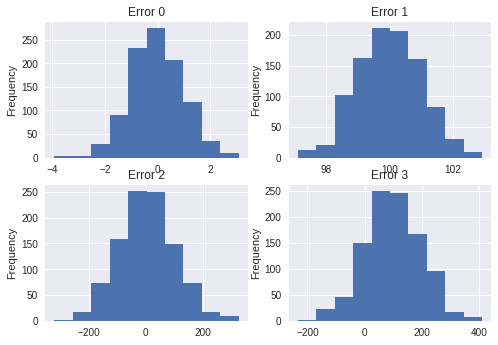

In [19]:
# Solution 1: 
# We can see from figures below that, in general, MAE is always no larger than 
# RMSE. Moreover, the higher the variance of error, the higher value a 
# difference between MAE and RMSE is. The source of high variance can come from
# either (a) the target values are corrupted with noise, or (b) our model fails
# to capture a detail in prediction's trend with respect to some attributes.

import numpy as np
import matplotlib.pyplot as plt 

# function to compute RMSE
def rmse(target, prediction):
    return np.sqrt(np.mean(np.square(target - prediction)))

# function to compute MAE
def mae(target, prediction):
    return np.mean(np.absolute(target - prediction))

# generate numbers running from 0 to 1
target = np.linspace(0, 1, num=1000)

# generate prediction error with different means and different variances
errors = [np.random.normal(loc=0.0, scale=1.0, size=1000), 
        np.random.normal(loc=100.0, scale=1.0, size=1000), 
        np.random.normal(loc=0.0, scale=100.0, size=1000), 
        np.random.normal(loc=100.0, scale=100.0, size=1000)]

# indices for plotting histograms of error
idx = [221, 222, 223, 224]


#prediction = []
for i in range(len(idx)):
  
    # Plotting histogram of errors
    plt.subplot(idx[i])
    plt.hist(errors[i])
    plt.title("Error " + str(i))
    plt.ylabel("Frequency")
    
    # Compute predictions, RMSE, MAE, and their difference
    prediction = target + errors[i]
    rmse_val = rmse(target, prediction)
    mae_val = mae(target, prediction)
    print("RMSE", i, ":", rmse_val)
    print("MAE", i, ":", mae_val)
    print("Difference :", rmse_val - mae_val)
    print()

plt.show()

2. Instead of dropping some datapoints that have missing values, we can try and fill them with a median of that attributes. Will the performance measure increase?

_Hint_: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html

_Extra hint_: Do you think that a median is always an appropriate value to use? What's about a mean or a mode? Which one would be appropriate for normally (Gaussian) distributed attribute? Which one would be appropriate for log-normal distribution or long-tailed distribution? (Search for a figure of these distributions on Google. It's useful for you to know at least what the shape of these distributions are and how frequent we can expect for each value in the distribution's range.)

_Extra extra hint_: Will our Machine Learning model always benefit from having these datapoints with filled attributes? How? What if the proportion of these datapoints is more than 50%? Also, what if the attribute is one of the main factors that affects the target value (e.g. number of rooms and a house price)? Will our Machine Learning model still be able to use and learn from such filled attributes?

In [0]:
Solution 2: 
Given that the attribute with missing values is important to make a prediction, 
filling the attribute is better than dropping the attribute, and consequently 
the performance measure will generally improve. Note that dropping datapoints 
results in less data for Machine Learning algorithm to train.

Additionally, other values such as a mean or a mode may even give a better 
performance than the median. A number of techniques can also be used to get 
values to fill. For further detail, have a quick look at this paper

Kotsiantis, S.B., Kanellopoulos, D. and Pintelas, P.E., 2006. Data preprocessing
for supervised leaning. International Journal of Computer Science, 1(2), 
pp.111-117.

3. What is the consequence of ignoring the datapoints with a capped value in our dataset?

_Hint_: By discarding those datapoints, you won't have them to let the Machine Learning model learn. When you roll out your Machine Learning project, what will then happen with a prediciton for inputs with those capped values?

In [0]:
Solution 3: 
Our prediction that bases on data with capped value is not reliable. Such a 
prediction is an extrapolation which must be treated carefully.

4. Instead of encoding a categorical attribute into a number of binary attributes, will our performance measure increase if we encode it into one attribute with each value representing one category? What could be a reason for such improvement?

_Hint_: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.factorize.html

_Extra hint_: What is the difference between ordinal data and categorical data? Can categorical data always be ordered according to some metrics? What will then be a consequence of coding categorical data into a numerical value?

In [0]:
Solution 4: 
Typically, such encoding is not appropriate for categorical attributes and 
consequently should not improve the performance of Machine Learning models. 
In particular, encoding such attributes into a numerical attribute will also 
embed the quantitative difference among each pair of categories which is usually
not true. Even if there is such a difference, the encoding has to preserve the 
original quantitative value as much as possible.

5. In many dataset including ours, different attributes have different ranges of value. Whilst our Machine Learning algorithm can cope with this issue to certain degree, it is widely known that either standardisation or normalisation should be applied. Try them separately on some attributes in our dataset, and observe any change in the performance measure.

_Hint_: http://scikit-learn.org/stable/modules/preprocessing.html

In [0]:
# Solution 5
from sklearn import preprocessing

scaled_train_features = preprocessing.scale(train_features)
# Other types of preprocessing can be looked in the hint

6. We had randomly partitioned the dataset into the train set and the test set. It might be the case that we were lucky and randomly chose a test set that yielded a very low RMSE. To properly evaluate performance of our Machine Learning algorithm, you should try using all datapoints in your dataset as a test set and make sure that the RMSE is significatly low. This is called 'Cross-Validation.' Try it with our dataset and one Machine Learning model.

_Hint_: http://scikit-learn.org/stable/modules/cross_validation.html

In [0]:
# Solution 6
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
scores = cross_val_score(reg, features, target, cv=5)
scores

7. Many Machine Learning algorithms including the Random Forest Regression have a number of parameters to tune. Try tuning our Random Forest Regressor so that it achieves the lowest RMSE.

_Hint_: Instead of manually tuning these parameters, you can try a search such as a grid search (http://scikit-learn.org/stable/modules/grid_search.html) to find a good combination of parameters.

In [0]:
# Solution 7
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [{'n_estimators': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19], 'max_depth': [10, 20, 30, 40, 50]}]

cv = GridSearchCV(RandomForestRegressor(), param_grid)
cv.fit(train_features, train_label)
print("Best parameters set found on development set:")
print(clf.best_params_)

# Detailed example of using GridSearchCV is accessible from 
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

8. In practice, after training your first prototype, you are likely to acquire new datapoints or update your existing datapoints. How can you utilise them to improve your Machine Learning algorithm?

_Hint_: Do those new datapoints significantly different to the previous one? If they do, you need to make your Machine Learning algorithm adapt to these new datapoints.

In [0]:
Solution 8: 
Given that a training of the Machine Learning model is not computationally 
expensive and not time-consuming, the new data can be incorporated into the 
dataset and the model can be trained freshly from the beginning. 

Contrarily, an online learning is required if the model is not easy to train. 
The key idea of an online learning is that an online training method of the 
Machine Learning model will learn from one datapoint or a small batch of data 
at each training epoch. Such a training method is different to the offline 
method and generally guarantees a well trained model given some conditions. 

For further information, have a quick look on the following sources:

Wikipedia contributors, 'Online machine learning', Wikipedia, The Free 
Encyclopedia, 27 September 2018, 05:30 UTC, <https://en.wikipedia.org/w/index.php?title=Online_machine_learning&oldid=861407129> 

Shalev-Shwartz, S., 2012. Online learning and online convex optimization. 
Foundations and Trends® in Machine Learning, 4(2), pp.107-194. <http://www.cs.huji.ac.il/~shais/papers/OLsurvey.pdf>